In [1]:
#import Packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, StratifiedKFold, GridSearchCV


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Model_dataset.csv')

In [3]:
df.head(5)

,Age,Gender,NPS,ChurnLabel,PurchaseFrequency,PurchaseValue,SubscriptionPlan,WebsitePageViews,WebsiteTimeSpent,EngagementMetricsLogins,...,FirstInteractionDate,LastInteractionDate,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,customer_segment
0,31,0,3,1,38,3994.72,0,49,15,19,...,2019-09-26,2021-07-25,523,722,3994.72,1,4,4,9,At_Risk
1,66,1,6,0,4,2844.35,1,100,9,9,...,2019-01-12,2022-12-13,17,36,2844.35,5,1,3,9,At_Risk
2,36,1,3,0,14,1866.52,2,1,97,19,...,2019-10-09,2022-01-04,360,266,1866.52,1,3,2,6,At_Risk
3,62,1,1,1,28,1378.64,3,25,31,4,...,2019-01-03,2022-11-10,50,112,1378.64,3,2,2,7,At_Risk
4,68,1,3,0,39,2425.05,4,77,51,12,...,2019-04-10,2022-12-19,11,468,2425.05,5,3,3,11,Loyal


Encode customer_segment

In [4]:
# Customer segment encoding
customer_segment_map = {'Lost': 0, 'At_Risk': 1, 'Loyal': 2, 'Premium': 3}

# Apply the mappings
df.loc[:,'customer_segment'] = df.loc[:, 'customer_segment'].map(customer_segment_map)

In [5]:
df.loc[0]

Age                                            31
Gender                                          0
NPS                                             3
ChurnLabel                                      1
PurchaseFrequency                              38
PurchaseValue                             3994.72
SubscriptionPlan                                0
WebsitePageViews                               49
WebsiteTimeSpent                               15
EngagementMetricsLogins                        19
EngagementMetricsFrequency                      0
FeedbackRating                                  1
MarketingCommunicationNoOfEmails                8
MarketingCommunicationOpenClickDiff         319.0
MarketingCommunicationSentOpenDiff          818.0
ServiceInteractions_Call                        1
ServiceInteractions_Email                       1
ServiceInteractions_Chat                        2
PaymentHistoryNoOfLatePayments                 40
ClickstreamData_Click                           4


In [6]:
X = df.drop(columns=['ChurnLabel','FirstInteractionDate', 'LastInteractionDate'])
y = df['ChurnLabel']

# Split the dataset into training and testing sets
X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.7, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_other, y_other, test_size=0.3, random_state=42)

In [7]:
# Normalize data
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
X_val = ss.transform(X_val)

#### **Feature Selection using Mutual Info Classif**

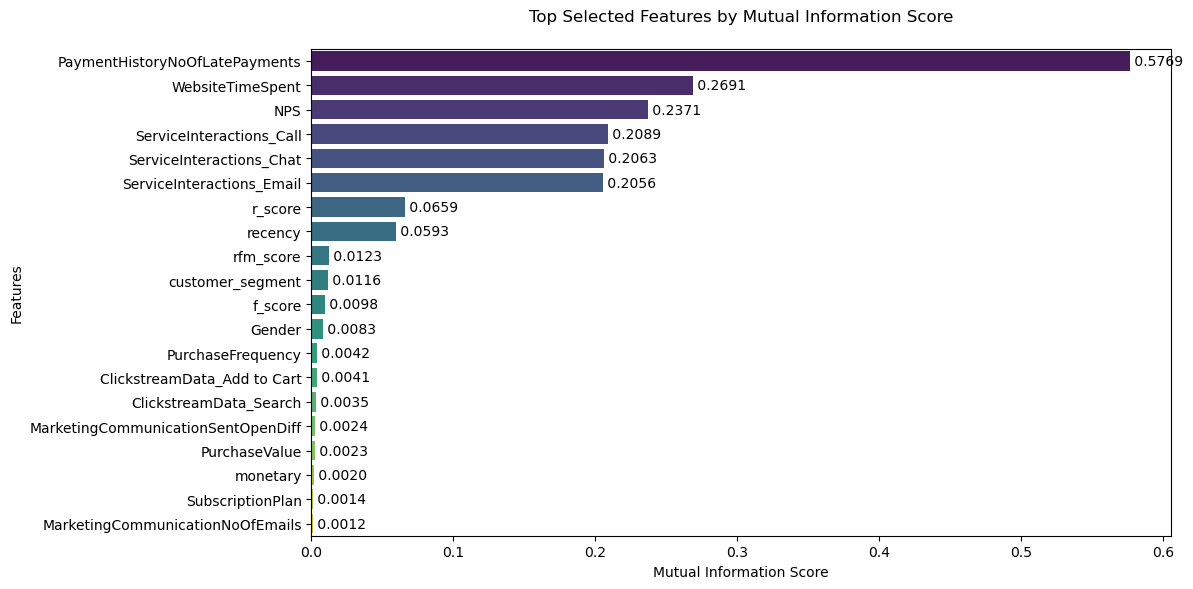

In [8]:
def select_features(X, y, n_features):
    selector = SelectKBest(score_func=mutual_info_classif, k=n_features)
    X_selected = selector.fit_transform(X, y)
    
    # Get selected feature names
    selected_features = X.columns[selector.get_support()].tolist()
    
    # Get scores for selected features
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': selector.scores_
    })
    feature_scores = feature_scores.sort_values('Score', ascending=False)
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Plot feature importance scores
    sns.barplot(data=feature_scores.head(n_features), 
                x='Score', 
                y='Feature',
                palette='viridis')
    
    plt.title('Top Selected Features by Mutual Information Score', pad=20)
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    
    # Add score values on bars
    for i, v in enumerate(feature_scores.head(n_features)['Score']):
        plt.text(v, i, f' {v:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return X_selected, selected_features, feature_scores

X_selected, selected_features, feature_scores = select_features(X, y, 20)

### Models
- LogisticRegression
- DecisionTreeClassifier

Metrics: 
- Accuracy score
- Precision score
- Recall score
- F1 score

In [9]:
def evaluate(X, y, model, subset=''):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='weighted')
    rec = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    
    print(f"Evaluation Metrics for {subset}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for {subset}')
    plt.show()
    
    # Plot ROC curve
    y_bin = label_binarize(y, classes=[0, 1])
    y_score = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y_bin, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {subset}')
    plt.legend(loc='lower right')
    plt.show()  
    
    # Feature importance
    if hasattr(model, 'coef_'):
        if isinstance(X, pd.DataFrame):
            feature_names = X.columns
        else:
            feature_names = [f'Feature_{i}' for i in range(X.shape[1])]
            
        # Handle multiclass or multilabel classifiers 
        if model.coef_.ndim > 1:
            coefs = np.abs(model.coef_).mean(axis=0) # Average coefficients across classes
        else:
            coefs = np.abs(model.coef_)
            
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': coefs
        }).sort_values(by='Importance', ascending=False)
    
        plt.figure(figsize=(12, 6))
        sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')
        plt.title(f'Feature Importance for {subset}')
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.show()
        
    # Classification report
    print(f"Classification Report for {subset}:\n", classification_report(y, y_pred, target_names=['Not Churned', 'Churned']))  
    return acc, prec, rec, f1

    # Cross-validation score
    def cross_validate(model, X, y, cv=5):
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        print(f"Cross-validation scores: {scores}")
        print(f"Mean accuracy: {scores.mean():.4f}")
        return scores.mean()

#### **Logistic Regression Model**

Evaluation Metrics for Training Set:
Accuracy: 0.9723
Precision: 0.9724
Recall: 0.9723
F1 Score: 0.9723


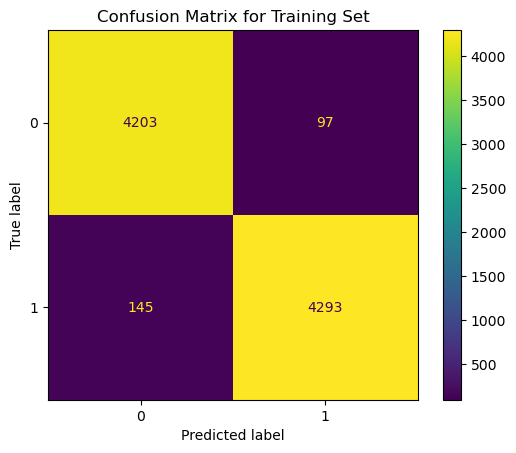

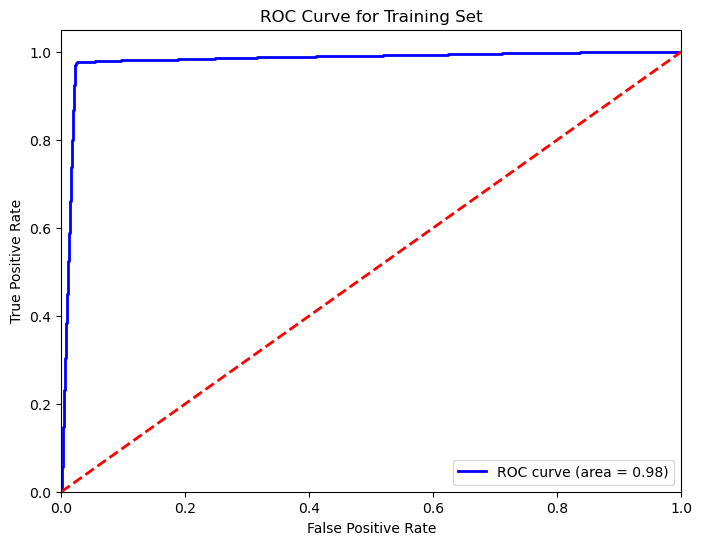

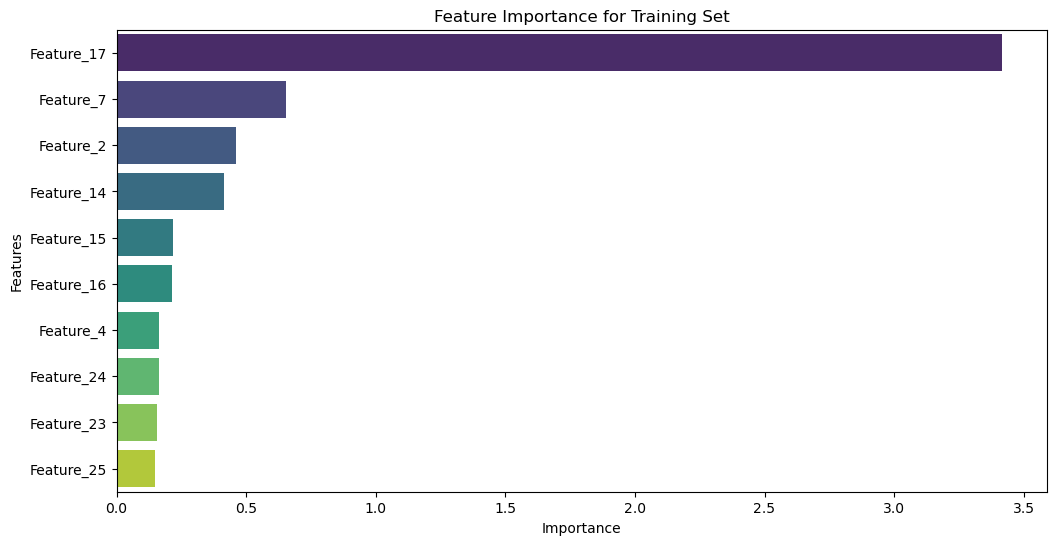

Classification Report for Training Set:
               precision    recall  f1-score   support

 Not Churned       0.97      0.98      0.97      4300
     Churned       0.98      0.97      0.97      4438

    accuracy                           0.97      8738
   macro avg       0.97      0.97      0.97      8738
weighted avg       0.97      0.97      0.97      8738

Evaluation Metrics for Validation Set:
Accuracy: 0.9662
Precision: 0.9663
Recall: 0.9662
F1 Score: 0.9662


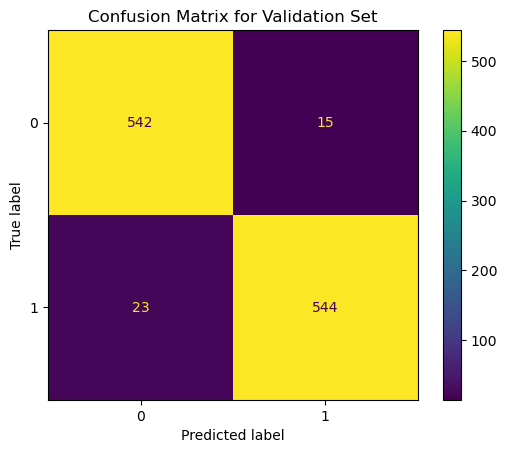

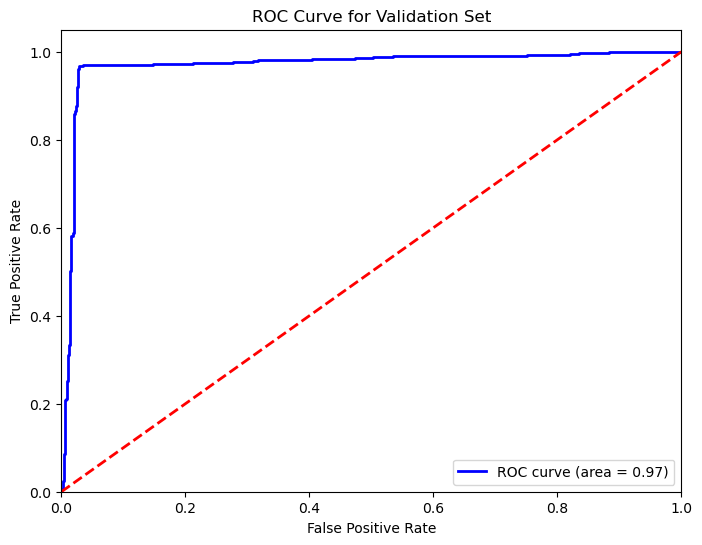

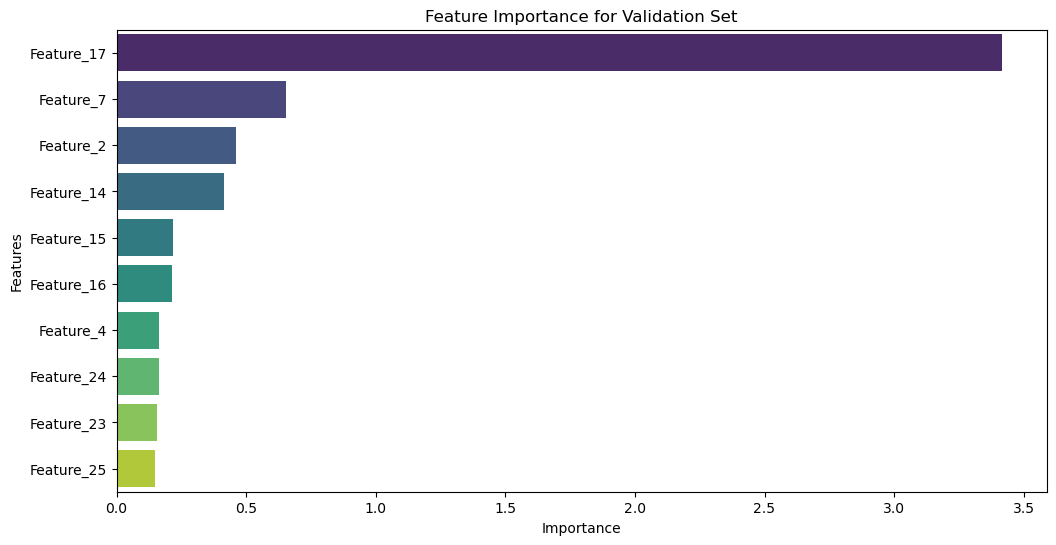

Classification Report for Validation Set:
               precision    recall  f1-score   support

 Not Churned       0.96      0.97      0.97       557
     Churned       0.97      0.96      0.97       567

    accuracy                           0.97      1124
   macro avg       0.97      0.97      0.97      1124
weighted avg       0.97      0.97      0.97      1124



(0.9661921708185054,
 0.9662909205204055,
 0.9661921708185054,
 0.9661925989784351)

In [10]:
# Build model
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Evaluate the model on training, validation, and test sets
evaluate(X_train, y_train, lr, subset='Training Set')
evaluate(X_val, y_val, lr, subset='Validation Set')

#### **Decision Tree Model**

Evaluation Metrics for Training Set:
Accuracy: 0.9778
Precision: 0.9778
Recall: 0.9778
F1 Score: 0.9778


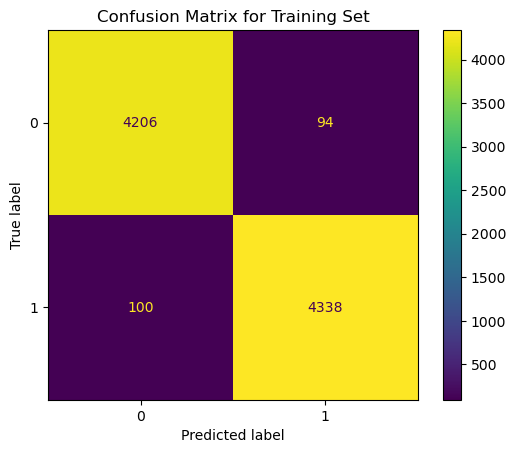

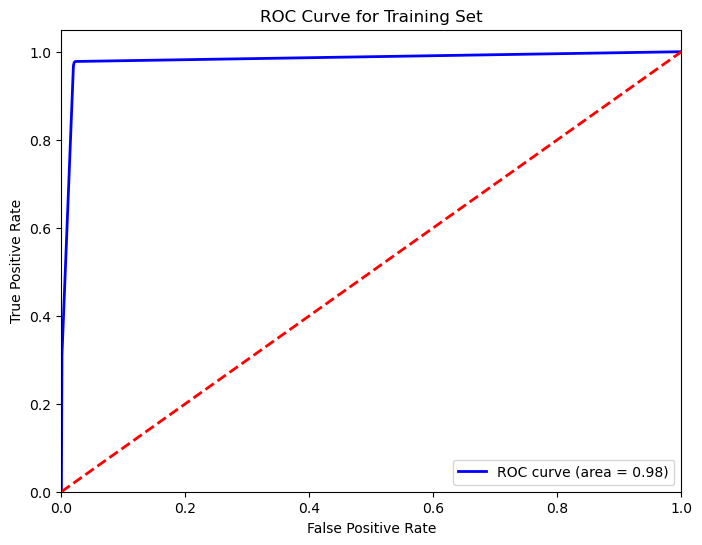

Classification Report for Training Set:
               precision    recall  f1-score   support

 Not Churned       0.98      0.98      0.98      4300
     Churned       0.98      0.98      0.98      4438

    accuracy                           0.98      8738
   macro avg       0.98      0.98      0.98      8738
weighted avg       0.98      0.98      0.98      8738

Evaluation Metrics for Validation Set:
Accuracy: 0.9698
Precision: 0.9698
Recall: 0.9698
F1 Score: 0.9698


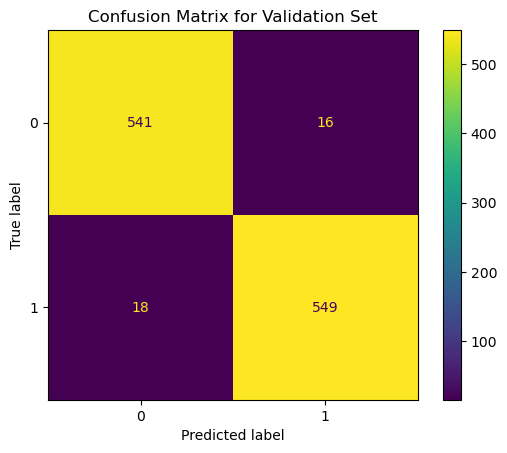

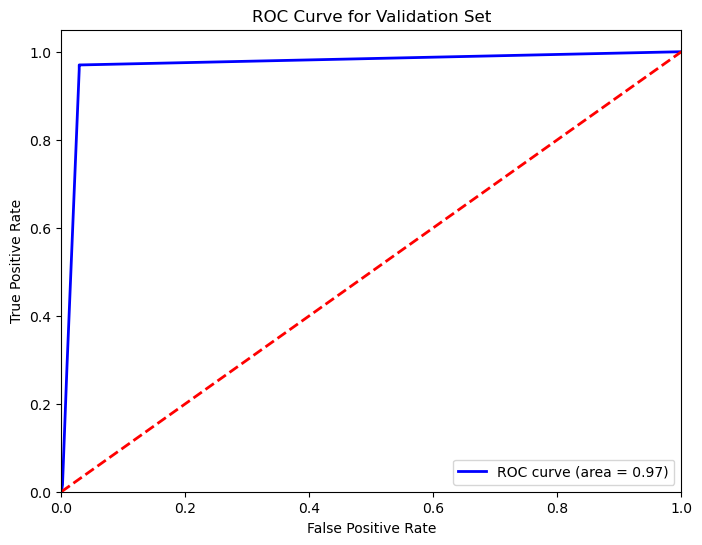

Classification Report for Validation Set:
               precision    recall  f1-score   support

 Not Churned       0.97      0.97      0.97       557
     Churned       0.97      0.97      0.97       567

    accuracy                           0.97      1124
   macro avg       0.97      0.97      0.97      1124
weighted avg       0.97      0.97      0.97      1124



(0.9697508896797153,
 0.9697577967503752,
 0.9697508896797153,
 0.9697512727883735)

In [11]:
# Build model
dt = DecisionTreeClassifier(max_depth = 5, random_state=42)
dt.fit(X_train, y_train)

# Evaluate the Decision Tree model on training, validation, and test sets
evaluate(X_train, y_train, dt, subset='Training Set')
evaluate(X_val, y_val, dt, subset='Validation Set')

Evaluation Metrics for Test Set:
Accuracy: 0.9706
Precision: 0.9706
Recall: 0.9706
F1 Score: 0.9706


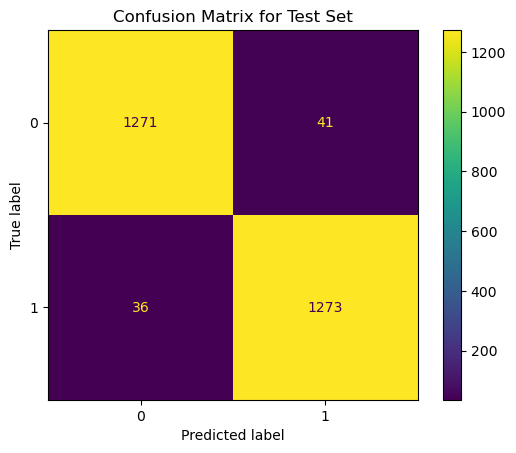

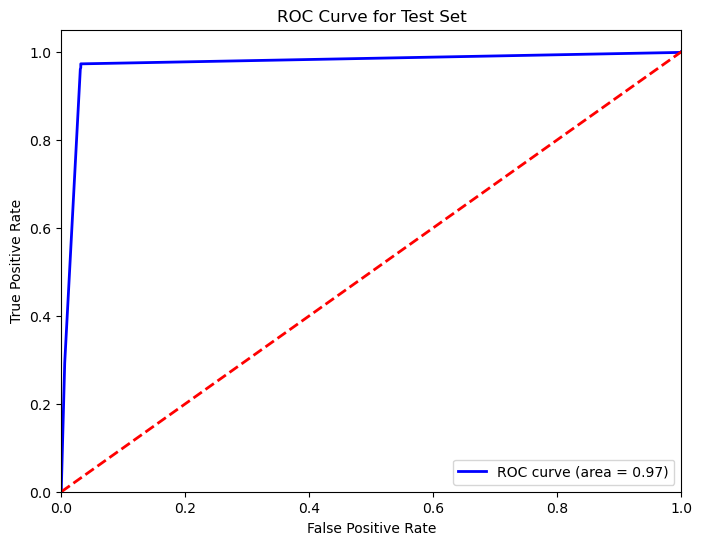

Classification Report for Test Set:
               precision    recall  f1-score   support

 Not Churned       0.97      0.97      0.97      1312
     Churned       0.97      0.97      0.97      1309

    accuracy                           0.97      2621
   macro avg       0.97      0.97      0.97      2621
weighted avg       0.97      0.97      0.97      2621

Evaluation Metrics for Test Set:
Accuracy: 0.9668
Precision: 0.9668
Recall: 0.9668
F1 Score: 0.9668


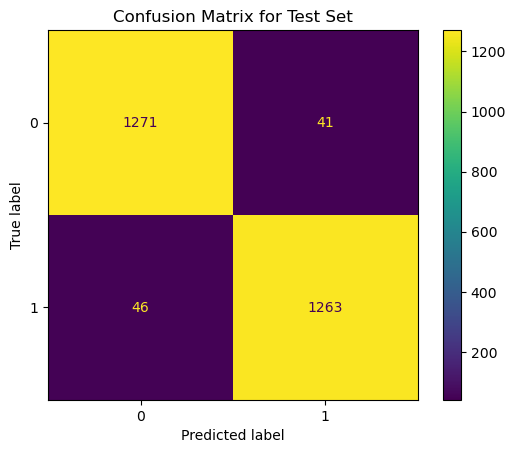

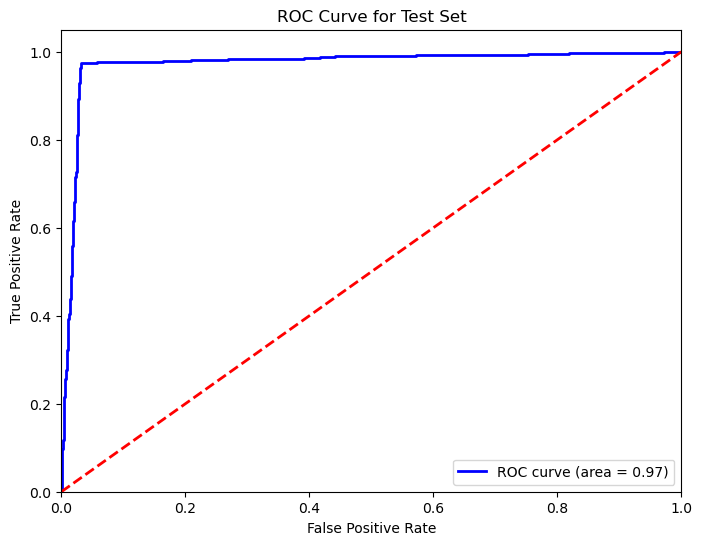

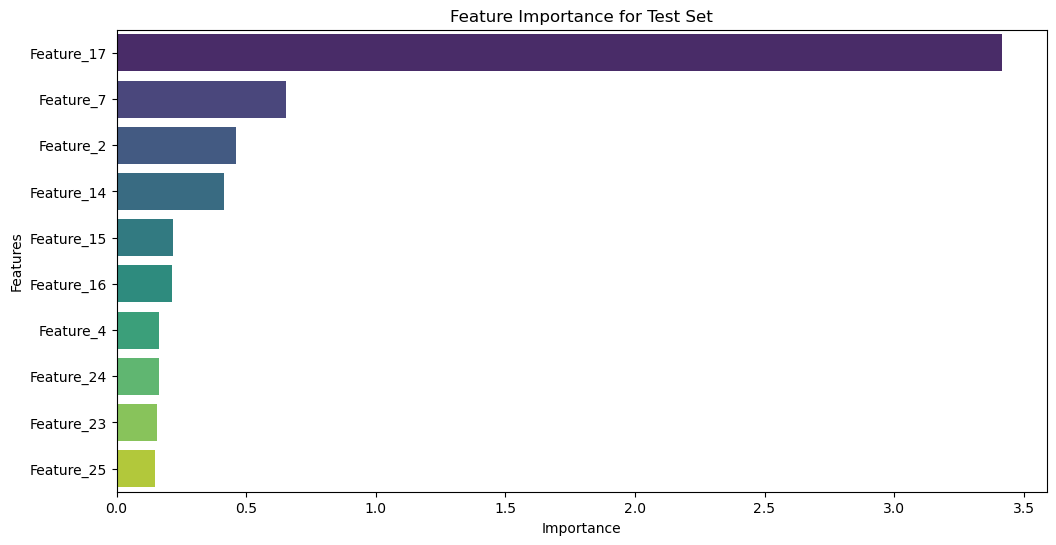

Classification Report for Test Set:
               precision    recall  f1-score   support

 Not Churned       0.97      0.97      0.97      1312
     Churned       0.97      0.96      0.97      1309

    accuracy                           0.97      2621
   macro avg       0.97      0.97      0.97      2621
weighted avg       0.97      0.97      0.97      2621



(0.9668065623807707,
 0.9668132127977329,
 0.9668065623807707,
 0.9668063691028579)

In [12]:
# Evaluate the Decision Tree model on test set
evaluate(X_test, y_test, dt, subset='Test Set')

# Evaluate the Logistic Regression model on test set
evaluate(X_test, y_test, lr, subset='Test Set')

#### **Hyperparameter Tuning**

Here, the aim is find the best way to produce the best model for both the logistic regression and decision tree model while ensuring no overfitting.

In [13]:
skfold_scores = StratifiedKFold(n_splits = 6, shuffle=True, random_state=42)
scores1 = cross_val_score(lr, X, y, cv=skfold_scores, scoring='recall')
print(f"Cross-validation scores for Logistic Regression: {scores1}")
scores2 = cross_val_score(dt, X, y, cv=skfold_scores, scoring='recall')
print(f"Cross-validation scores for Decision Tree: {scores2}")

Cross-validation scores for Logistic Regression: [0.9648623  0.96011396 0.97053232 0.96577947 0.97908745 0.95437262]
Cross-validation scores for Decision Tree: [0.97150997 0.97150997 0.97718631 0.97243346 0.98574144 0.96102662]


#### **Best Parameters Using GridSearch**

In [14]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,                   # 5-fold cross-validation
    scoring='accuracy',     # or 'f1', 'roc_auc', etc.
    n_jobs=-1,              # use all available CPU cores
    verbose=2
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best hyperparameters and model
print("Best Parameters:", grid_search.best_params_)
best_model_dt = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model_dt.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=3, min_samples_lea

In [15]:
# Define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],           # Lasso or Ridge
    'C': [0.01, 0.1, 1, 10, 100],      # Regularization strength (lower = stronger)
    'class_weight': [None, 'balanced']
}

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',  # Or 'f1', 'roc_auc', etc.
    n_jobs=-1,
    verbose=2
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
best_model_lr = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model_lr.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ..............C=0.01, class_weight=None, penalty=l1; total time=   0.0s
[CV] END ..............C=0.01, class_weight=None, penalty=l1; total time=   0.0s
[CV] END ..............C=0.01, class_weight=None, penalty=l1; total time=   0.0s
[CV] END ..............C=0.01, class_weight=None, penalty=l1; total time=   0.0s
[CV] END ..............C=0.01, class_weight=None, penalty=l1; total time=   0.0s
[CV] END ..........C=0.01, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ..............C=0.01, class_weight=None, penalty=l2; total time=   0.0s
[CV] END ..........C=0.01, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ..............C=0.01, class_weight=None, penalty=l2; total time=   0.0s
[CV] END ..........C=0.01, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ..........C=0.01, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ..............C=0.01, class_weight=Non

Evaluation Metrics for Test Set:
Accuracy: 0.9714
Precision: 0.9714
Recall: 0.9714
F1 Score: 0.9714


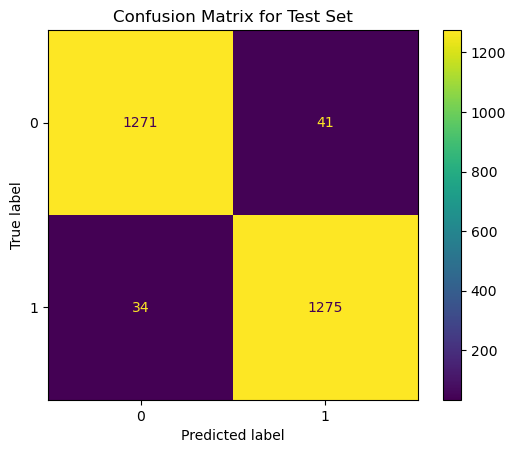

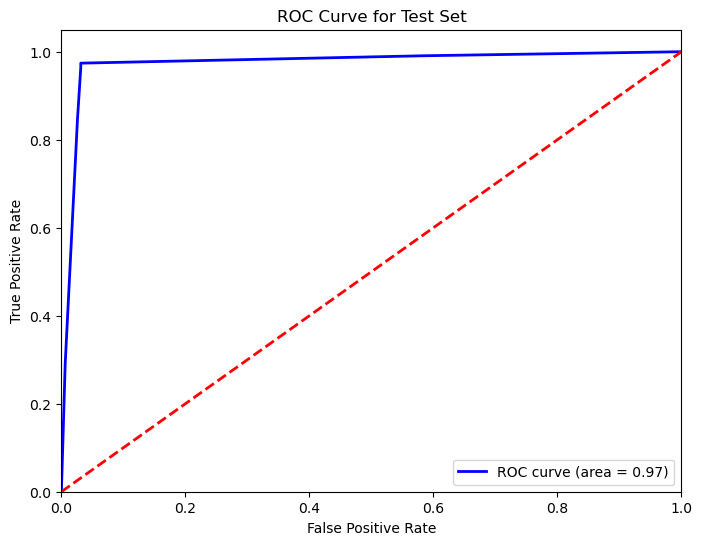

Classification Report for Test Set:
               precision    recall  f1-score   support

 Not Churned       0.97      0.97      0.97      1312
     Churned       0.97      0.97      0.97      1309

    accuracy                           0.97      2621
   macro avg       0.97      0.97      0.97      2621
weighted avg       0.97      0.97      0.97      2621

Evaluation Metrics for Test Set:
Accuracy: 0.9668
Precision: 0.9668
Recall: 0.9668
F1 Score: 0.9668


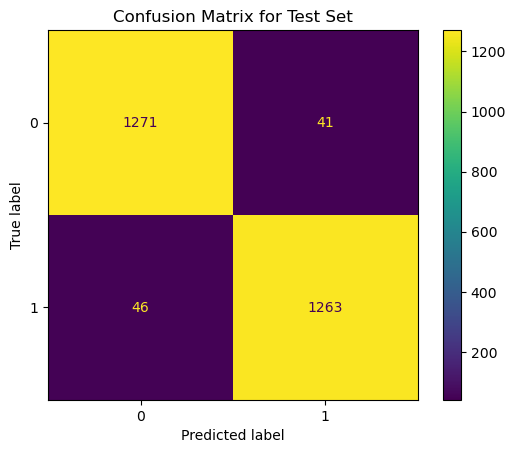

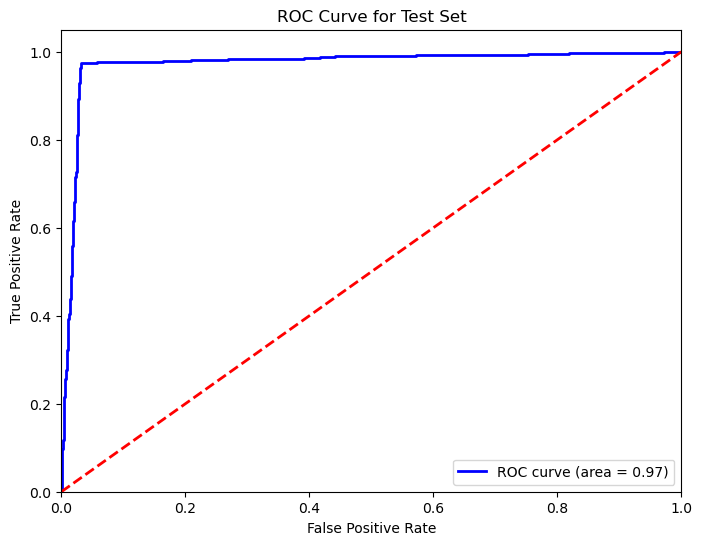

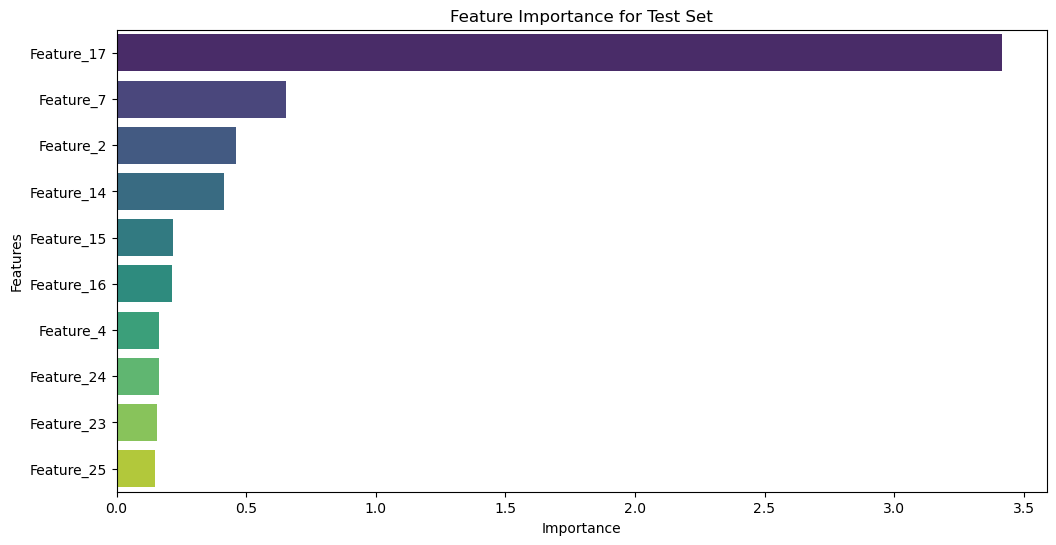

Classification Report for Test Set:
               precision    recall  f1-score   support

 Not Churned       0.97      0.97      0.97      1312
     Churned       0.97      0.96      0.97      1309

    accuracy                           0.97      2621
   macro avg       0.97      0.97      0.97      2621
weighted avg       0.97      0.97      0.97      2621



(0.9668065623807707,
 0.9668132127977329,
 0.9668065623807707,
 0.9668063691028579)

In [16]:
# Train it
best_model_lr.fit(X_train, y_train)
best_model_dt.fit(X_train, y_train)

# Evaluate the Decision Tree model on test set
evaluate(X_test, y_test, best_model_dt, subset='Test Set')

# Evaluate the Logistic Regression model on test set
evaluate(X_test, y_test, best_model_lr, subset='Test Set')

#### **Best Parameters Using RandomizedSearchCV**

In [17]:
# Create Stratified K-Folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Logistic Regression Hyperparameter Grid ---
lr = LogisticRegression(solver='liblinear', random_state=42)

param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'class_weight': [
        {0: 0.5, 1: 0.5},
        {0: 0.4, 1: 0.6},
        {0: 0.3, 1: 0.7},
        {0: 0.2, 1: 0.8}
    ]
}

grid_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_grid_lr,
    cv=cv,
    n_iter=10,
    scoring='recall',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# --- Decision Tree Hyperparameter Grid ---
dt = DecisionTreeClassifier(random_state=42)

param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [
        {0: 0.5, 1: 0.5},
        {0: 0.4, 1: 0.6},
        {0: 0.3, 1: 0.7},
        {0: 0.2, 1: 0.8}
    ]
}

grid_dt = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_grid_dt,
    cv=cv,
    n_iter=10,
    scoring='recall',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# --- Fit both models ---
grid_lr.fit(X_train, y_train)
grid_dt.fit(X_train, y_train)

# --- Evaluate Logistic Regression ---
print("\nBest Parameters (Logistic Regression):", grid_lr.best_params_)
lr_best = grid_lr.best_estimator_
y_pred_lr = lr_best.predict(X_test)
print("\nLogistic Regression Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# --- Evaluate Decision Tree ---
print("\nBest Parameters (Decision Tree):", grid_dt.best_params_)
dt_best = grid_dt.best_estimator_
y_pred_dt = dt_best.predict(X_test)
print("\nDecision Tree Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ....C=10, class_weight={0: 0.5, 1: 0.5}, penalty=l1; total time=   0.2s
[CV] END ....C=10, class_weight={0: 0.5, 1: 0.5}, penalty=l1; total time=   0.2s
[CV] END ...C=0.1, class_weight={0: 0.2, 1: 0.8}, penalty=l2; total time=   0.2s
[CV] END ...C=0.1, class_weight={0: 0.2, 1: 0.8}, penalty=l2; total time=   0.2s
[CV] END ...C=0.1, class_weight={0: 0.2, 1: 0.8}, penalty=l2; total time=   0.2s
[CV] END ....C=10, class_weight={0: 0.3, 1: 0.7}, penalty=l2; total time=   0.3s
[CV] END ....C=10, class_weight={0: 0.3, 1: 0.7}, penalty=l2; total time=   0.3s
[CV] END ...C=0.1, class_weight={0: 0.2, 1: 0.8}, penalty=l2; total time=   0.2s
[CV] END ...C=0.1, class_weight={0: 0.2, 1: 0.8}, penalty=l2; total time=   0.2s
[CV] END ....C=10, class_weight={0: 0.3, 1: 0.7}, penalty=l2; total time=   0.3s
[CV] END ....C=10, class_weight={0: 0.3, 1: 0.7}, penalty=l2; total time=   0.3s
[CV] END ....C=10, class_weight={0: 0.3, 1: 0.7}